In [3]:
import pandas as pd 

df = pd.read_csv("../reports/final_predictions_Reddit_Climate_FR.csv", index_col=0)
df.head(2)

index    action  no action   entropy prediction     kind       id  \
0    0.0  0.520532   0.479468  0.692304     action     post  1lp0qs9   
1    1.0  0.474236   0.525764  0.691819  no action  comment  n0r4yvr   

  parent_id              created subreddit  \
0       NaN  2025-07-01 12:46:33    france   
1   1lp0qs9  2025-07-01 13:15:45    france   

                                                body  score  \
0  Les arguments massus contre les climato-scepti...      0   
1  De la part d'un confrère physicien.    \n\nUn ...      1   

                                                 url  
0  https://www.reddit.com/r/france/comments/1lp0q...  
1                                                NaN

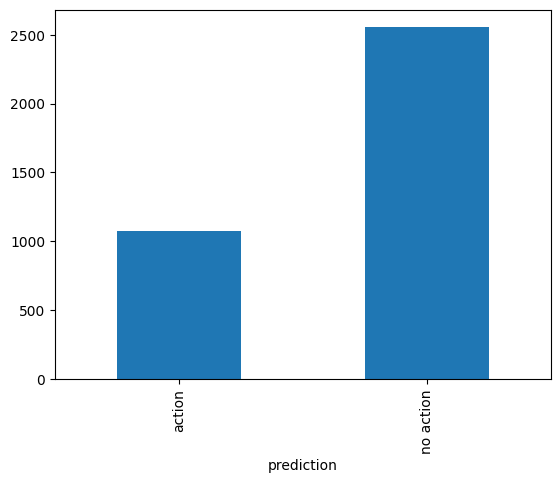

In [9]:
df.groupby("prediction").size().plot(kind="bar");

In [20]:
print(f'average upvote score is: {round(df.score.sum()/len(df),1)}')

average upvote score is: 25.4


Messages without cues to action have higher engagement scores

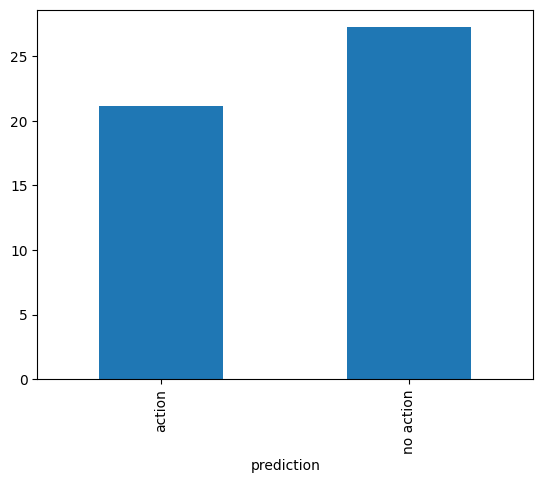

In [15]:
df.groupby("prediction")["score"].mean().plot(kind="bar");

# Berttopic
Given project time constraints, we will perform clustering on the cues to action.
Given more time we would create labels (solar, wind, nuclear, consume less, capture CO2, etc) and annotate for supervised classification.

In [ ]:
!huggingface-cli login hf_XXX

In [ ]:

import pandas as pd, re, unicodedata, nltk
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from bertopic import BERTopic
import plotly.io as pio
pio.renderers.default = "notebook"   


action_df = df[df["prediction"] == "action"]                          

texts = action_df["body"].astype(str).tolist()
print(f"{len(texts):,} action tweets to cluster")

# cleaning 
def clean(txt: str) -> str:
    txt = re.sub(r"http\S+|@\w+|#\w+", " ", txt.lower())
    txt = unicodedata.normalize("NFKD", txt).encode("ascii", "ignore").decode()
    return txt

texts = [clean(t) for t in texts]

# removing stopwords
nltk.download("stopwords", quiet=True)
fr_stop = set(nltk.corpus.stopwords.words("french"))

# #reworking the stopword list
fr_stop.update({
    "ca", "ça", "tout", "plus", "faire", "sais", "meme", "même", "bien",
    "donc", "encore", "peut", "veut", "voir", "rt", "lol", "okay","si","etre", "faire", "comme", "faut", "peut", "doit", "si", "tout","fait","gens","quand",
    "aussi","cest","tres"
})

#  Vectorizer (skip 1-letter tokens, use uni- & bi-grams)
vectorizer = CountVectorizer(
    stop_words=list(fr_stop),
    token_pattern=r"(?u)\b\w\w+\b",   # ignore 1-letter tokens
    ngram_range=(1, 2),
    min_df=3                          # drop very rare terms
)


# Sentence-Transformer encoder  (public, multilingual)
emb_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",token="hf_XXX" # replace with your own token from huggingface
)

# HDBSCAN 
hdbscan = HDBSCAN(
    min_cluster_size=25,     # 20 ≈ 2 % of 1 000
    min_samples=5,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)


#Fit BERTopic
topic_model = BERTopic(
    embedding_model=emb_model,
    vectorizer_model=vectorizer,
    hdbscan_model=hdbscan,
    language="french",
    min_topic_size=25,
    calculate_probabilities=True
)

topics, probs = topic_model.fit_transform(texts)

# quick table
print(topic_model.get_topic_info().head(15))

# bubble chart (topics)
fig_topics = topic_model.visualize_topics()
fig_topics.show()          # appears inline

# scatter chart (each tweet)
fig_docs = topic_model.visualize_documents(texts, topics=topics)
fig_docs.show()            # appears inline

print("\n✓ Finished — open the two HTML files to explore clusters.")


1,075 action tweets to cluster
    Topic  Count                                           Name  \
0      -1    253                        -1_moins_energie_co2_va   
1       0    189                          0_monde_peu_sans_rien   
2       1    188                   1_chaleur_clim_air_chauffage   
3       2     88             2_emissions_carbone_co2_climatique   
4       3     63          3_voiture_energie_electrique_batterie   
5       4     53                       4_avion_train_prix_moins   
6       5     52                5_ecologie_viande_droite_gauche   
7       6     37         6_production_solaire_renouvelables_twh   
8       7     35  7_capitalisme_systeme_covoiturage_capitaliste   
9       8     34                8_petrole_ue_pays_hydrocarbures   
10      9     30    9_nucleaire_uranium_renouvelables_centrales   
11     10     28                    10_eau_lisier_ruisseau_leau   
12     11     25              11_gaz_nucleaire_rendement_france   

                              


✓ Finished — open the two HTML files to explore clusters.
